In [13]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import pystan
from scipy.stats import truncnorm
import arviz as az

<h2>Theory</h2>

In [14]:
#Theoretical model
def replicate_f(rho,tc):
    temp= lambda x : stats.norm.pdf(x)*stats.norm.cdf((rho*x-tc)/np.sqrt(1-rho**2))
    return sp.integrate.quad(temp, a=tc, b=np.inf)
 
def replicate(tau=.1, sigma=0, epsilon=1, n=30, alpha=0.05):
    tc = sp.stats.norm.ppf(1-alpha/2)
    tc = (epsilon/np.sqrt(n))*tc/np.sqrt((epsilon**2)/n + tau**2 + sigma**2)
    rho = tau**2/(epsilon**2/n + tau**2 + sigma**2)
    return(replicate_f(rho,tc)/stats.norm.cdf(-tc))[0]
                                                
def publish(tau=.1, sigma=0, epsilon=1, n=30, alpha=0.05):
    tc = sp.stats.norm.ppf(1-alpha/2)
    tc = (epsilon/np.sqrt(n))*tc/np.sqrt((epsilon**2)/n + tau**2 + sigma**2)
    return(2*sp.stats.norm.cdf(-tc))

def type_s(tau=.4, sigma=.2, epsilon=1, n=100, alpha=0.05):
    tc = sp.stats.norm.ppf(1-alpha/2)
    tc = (epsilon/np.sqrt(n))*tc
    
    temp= lambda x : stats.truncnorm(0,np.inf,scale=tau).pdf(x) * \
                     stats.norm(loc=x,scale=np.sqrt((epsilon**2)/n + sigma**2)).cdf(-tc)
    
    return(sp.integrate.quad(temp, a=0, b=np.inf))[0] 

def type_m(tau=.4, sigma=.2, epsilon=1, n=100, alpha=0.05):
    tc = sp.stats.norm.ppf(1-alpha/2)
    tc = (epsilon/np.sqrt(n))*tc
    above = truncnorm(tc,np.inf,0, scale=np.sqrt((epsilon**2)/n + tau**2 + sigma**2)).stats()[0]
    below = truncnorm(-np.inf,-tc, 0, scale=np.sqrt((epsilon**2)/n + tau**2 + sigma**2)).stats()[0]
    a = type_s(tau, sigma, epsilon, n, alpha)
    return (above*(1-a) + a * (below))-tau

type_m_vec = np.vectorize(type_m)
type_s_vec = np.vectorize(type_s)
replicate_vec = np.vectorize(replicate)
publish_vec = np.vectorize(publish)

<h3>Figure 1</h3>

In [15]:
pal = sns.color_palette("colorblind", n_colors=6)
def plot_figure_1(axs):
    
    #ax1.plot(np.linspace(0,2,100), stats.norm(0,.2).pdf(np.linspace(0,2,100)),color=pal[0])
    ax1.fill_between(np.linspace(0,2,100), 
                     np.zeros(100),
                     stats.norm(0,.2).pdf(np.linspace(0,2,100)),
                     color=pal[0],alpha=.5)
    ax1.plot([0, .2], [1.2, 1.2],color='k')
    ax1.text(x=.1,y=1.25, s=r'$\tau$',fontsize='x-large',color='k')

    ax1.text(x=.2,y=2.1, s=r'$d_{true}$',fontsize='x-large')

    ax1.set_xlabel('abs(Effect size)')
    ax1.set_ylabel('Density')



    ax1.text(x=.1,y=1.25, s=r'$\tau$',fontsize='x-large')
    ax1.plot([0.25, .35], [1.2, 1.2],color='k')



    ax1.plot([.25,.25], [0, 2],color='k',ls='--')
    ax1.text(x=.28,y=1.25, s=r'$\sigma$',fontsize='x-large',color='k')


    #ax1.plot(np.linspace(0,2,100), stats.norm(loc=0.25,scale=0.1).pdf(np.linspace(0,2,100))/2,color=pal[1])

    ax1.fill_between(np.linspace(0,2,100),
                     np.zeros(100),
                     stats.norm(loc=0.25,scale=0.1).pdf(np.linspace(0,2,100))/2,color=pal[1],alpha=.3)

    ax1.set_xlim(0,.8)
    ax1.set_ylim(0,2.3)

    ax1.plot([0.1,0.1],[0,stats.norm(loc=0.25,scale=0.1).pdf(0.1)/2],ls='--',color='k',zorder=3)
    ax1.text(x=.4,y=.7, s=r'$d_{orig.}$',fontsize='x-large')


    ax1.plot([0.4,0.4],[0,stats.norm(loc=0.25,scale=0.1).pdf(0.4)/2],ls='--',color='k')
    ax1.text(x=.1,y=.7, s=r'$d_{rep.}$',fontsize='x-large')

    ax1.plot([.28,.28],[0,.4],color='k')
    ax1.text(x=.3,y=.25, s=r'$t_{crit.}$',fontsize='x-large')

    ax1.fill_between(np.linspace(0,2,100),
                     np.zeros(100),
                     stats.norm(loc=0.4,scale=0.14).pdf(np.linspace(0,2,100))/8,color=pal[2],alpha=.3)

    ax1.text(x=.45,y=.1, s=r'$\frac{\epsilon}{\sqrt{n}}$',fontsize='x-large')
    ax1.plot([0.4, .5], [0.27, 0.27],color='k')
    ax1.set_xticks(np.linspace(0,1,11))

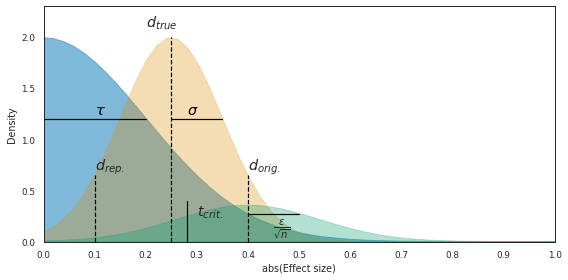

In [16]:
fig = plt.figure(figsize=(8,4))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, :])
sns.set_style('white')
#ax2 = fig.add_subplot(gs[1,0])
#ax3 = fig.add_subplot(gs[1,1])
plot_figure_1(ax1)
plt.tight_layout()
plt.savefig('./output/Figure1.png',transparent=False)

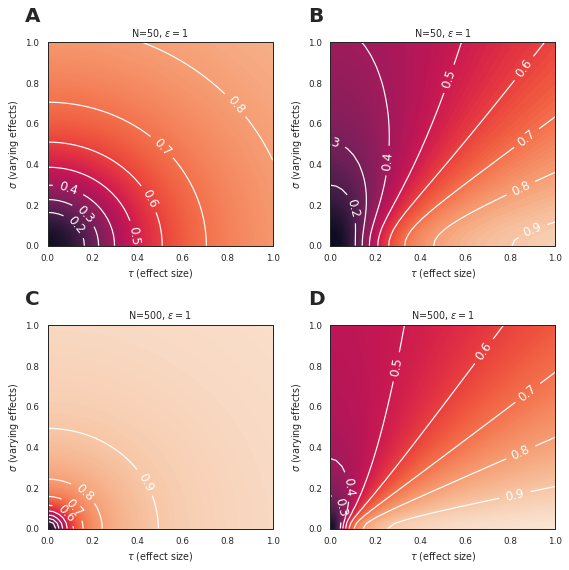

In [17]:
sns.set_context('paper',font_scale=1)
sns.set_palette(sns.color_palette("dark:salmon"))

fig, axs = plt.subplots(2,2,figsize=(8,8))

res = 40
N=50

axs0 = axs[0][0]
sns.set_context('paper')
x= np.linspace(0, 1.0, res)
y = np.linspace(0,1.0, res)
X, Y =  np.meshgrid(x,y)
Z = publish_vec(tau=X, sigma=Y, epsilon=1, n=N)
lls = np.linspace(.2,1,9)
CS= axs0.contour(X, Y, Z,levels=lls,zorder=2,colors='white')
axs0.clabel(CS, colors = 'w', fontsize=12) #contour line labels
levels = np.linspace(.0,1,1000)
CSF= axs0.contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("rocket",as_cmap=True))
axs0.set_ylabel(r'$\sigma$' + ' (varying effects)')
axs0.set_xlabel(r'$\tau$' + ' (effect size)')
axs0.set_title('N=50, ' + r'$\epsilon=1$')


axs1 = axs[0][1]

x= np.linspace(0, 1.0, res)
y = np.linspace(0,1.0, res)
X, Y =  np.meshgrid(x,y)
Z = replicate_vec(X, Y,1,N,.05)

CS= axs1.contour(X, Y, Z,levels=lls,zorder=2,colors='white')
axs1.clabel(CS, colors = 'w', fontsize=12) #contour line labels

levels = np.linspace(.0,1,100)
CSF= axs1.contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("rocket",as_cmap=True))
axs1.set_ylabel(r'$\sigma$' + ' (varying effects)')
axs1.set_xlabel(r'$\tau$' + ' (effect size)')
axs1.set_title('N=50, ' + r'$\epsilon=1$')

x= np.linspace(0, 1.0, res)
y = np.linspace(0,1.0, res)
X, Y =  np.meshgrid(x,y)
Z = replicate_vec(X, Y,1,500,.05)


axs2 = axs[1][1]
sns.set_context('paper',font_scale=1)
sns.set_palette(sns.color_palette("dark:salmon"))
lls = np.linspace(.3,1,8)
CS= axs2.contour(X, Y, Z,levels=lls,zorder=2,colors='white')
axs2.clabel(CS, colors = 'w', fontsize=12) #contour line labels
levels = np.linspace(.0,1,500)
CSF= axs2.contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("rocket",as_cmap=True))
axs2.set_ylabel(r'$\sigma$' + ' (varying effects)')
axs2.set_xlabel(r'$\tau$' + ' (effect size)')
axs2.set_title('N=500, ' + r'$\epsilon=1$')


axs3 = axs[1][0]
sns.set_context('paper')
x= np.linspace(0, 1.0, res)
y = np.linspace(0,1.0, res)
X, Y =  np.meshgrid(x,y)
Z = publish_vec(tau=X, sigma=Y, epsilon=1, n=1000)
ax = plt.gca()
lls = np.linspace(.2,1,9)
CS= axs3.contour(X, Y, Z,levels=lls,zorder=2,colors='white')
ax.clabel(CS, colors = 'w', fontsize=12) #contour line labels
levels = np.linspace(.0,1,500)
CSF= axs3.contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("rocket",as_cmap=True))
axs3.set_ylabel(r'$\sigma$' + ' (varying effects)')
axs3.set_xlabel(r'$\tau$' + ' (effect size)')
axs3.set_title('N=500, ' + r'$\epsilon=1$')

axs = axs.flat
import string
for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
plt.tight_layout()
plt.savefig('./output/figure2.png',dpi=750)

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(8,8))
res = 40

x= np.linspace(0, 1.0, res)
n = np.linspace(10,1000, res)
N,X =  np.meshgrid(n,x)
Z = publish_vec(tau=0.2, sigma=X, epsilon=1, n=N)

lls = np.linspace(.2,1,9)
CS= axs[0][0].contour(N,X, Z,levels=lls,zorder=2,colors='white')
axs[0][0].clabel(CS, colors = 'w', fontsize=12) #contour line labels
levels = np.linspace(.0,1,1000)
axs[0][0].plot([10,1000],[.2,.2],color='k',ls='--',alpha=.5)
CSF= axs[0][0].contourf(N,X, Z,zorder=1,levels=levels,cmap=sns.color_palette("rocket",as_cmap=True))
axs[0][0].set_ylabel(r'$\sigma$' + ' (varying effects)')
axs[0][0].set_xlabel('Sample size')

x= np.linspace(0, 1.0, res)
n = np.linspace(10,1000, res)
N,X =  np.meshgrid(n,x)
Z = replicate_vec(tau=0.2, sigma=X, epsilon=1, n=N)
lls = np.linspace(.2,1,9)
CS= axs[0][1].contour(N,X, Z,levels=lls,zorder=2,colors='white')
axs[0][1].clabel(CS, colors = 'w', fontsize=12) #contour line labels
levels = np.linspace(.0,1,1000)
CSF= axs[0][1].contourf(N,X, Z,zorder=1,levels=levels,cmap=sns.color_palette("rocket",as_cmap=True))
axs[0][1].set_ylabel(r'$\sigma$' + ' (varying effects)')
axs[0][1].set_xlabel('Sample size')
axs[0][1].plot([10,1000],[.2,.2],color='k',ls='--',alpha=.5)


x= np.linspace(0.001, 1, res)
y = np.linspace(0.001,1, res)
X, Y =  np.meshgrid(x,y)
Z = type_s_vec(X, Y,1,50,.05) 


lls = np.linspace(0,1,11)
CS= axs[1][0].contour(X, Y, Z,zorder=2,levels=lls, colors='white')
axs[1][0].clabel(CS, colors = 'w', fontsize=12) #contour line labels

levels = np.linspace(0,1,100)
CSF= axs[1][0].contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("rocket",as_cmap=True))
axs[1][0].set_ylabel(r'$\sigma$' + ' (varying effects)')
axs[1][0].set_xlabel(r'$\tau$' + ' (effect size)')
axs[1][0].set_title('N=50, ' + r'$\epsilon=1$')   


x= np.linspace(0.001, 1, res)
y = np.linspace(0.001,1, res)
X, Y =  np.meshgrid(x,y)

Z = type_m_vec(X, Y,1,50,.05) 


lls = np.linspace(-1,1,21)
CS= axs[1][1].contour(X, Y, Z,zorder=2,levels=lls, colors='white')
axs[1][1].clabel(CS, colors = 'w', fontsize=12) #contour line labels

levels = np.linspace(-1,1,100)
CSF= axs[1][1].contourf(X, Y, Z,zorder=1,levels=levels, 
                        cmap=sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True))

axs[1][1].set_ylabel(r'$\sigma$' + ' (varying effects)')
axs[1][1].set_xlabel(r'$\tau$' + ' (effect size)')
axs[1][1].set_title('N=50, ' + r'$\epsilon=1$')   

import string
axs = axs.flat
for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
    
plt.tight_layout()
plt.savefig('./output/figure3.png',dpi=750)